# Benchmark

## *Table of contents*
* *Setup Phase*
	1. Import libraries and queries
	2. Showing all the available queries
	3. Query selection

* *Evaluation Phase*
	1. Precision at Standard Recall Levels for query Q
	2. Interpolated Average Precision (IAP) at Standard Recall Leveles
	3. R-Precision
	4. Mean Average Precision (MAP)
	5. F-Measure & E-Measure 

## *Setup phase*

### Import libraries and queries

In [29]:
import os
import json
from whoosh.scoring import BM25F
from doc2vec.doc2vec_model import Doc2VecModel
from sentiment.sentiment_model import SentimentWeightingModel, AdvancedSentimentWeightingModel

import seaborn as sns
import pandas as pd

# file containing benchmark queries
file_path = os.path.join("evaluation", "queries.json")

# loades the queries
with open(file_path) as f:
    queries = json.load(f)

# Models that need to be tested. 
models = [
	(BM25F(), "BM25F"),
 	(Doc2VecModel(), "Doc2Vec"),
	(SentimentWeightingModel(), "Base Sentiment"),
	(AdvancedSentimentWeightingModel(), "Advanced Sentiment" ) 
]

### Showing all the available queries

In [30]:
indexes, uin = [i for i in range(len(queries))], [k["UIN"] for k in queries]
print('ID \t UIN')
print('\n'.join([f"{x[0]} \t {x[1]}" for x in list(zip(indexes, uin))]))

ID 	 UIN
0 	 I need an apartment near st james park
1 	 enjoyable double room where i could stay with my dog.
2 	 I'm a student looking for a budget-friendly hostel in Kensington or Westminster. I don't care about having all kind of amenities.
3 	 I'm looking for a luxurious apartment in Kensington for a family of four, with two bathrooms and a beautiful view.
4 	 I need a cheap place in Camden that allows dogs, ideally with a minimum rating of 3 stars.
5 	 I'm searching an affordable place. I need a low-cost apartment in Hillingdon for two people, with at least one bed and one bathroom. Max budget is €100.
6 	 My partner and I are looking for a romantic getaway in Richmond upon Thames. We want an apartment rated at least 4 stars.
7 	 I need a budget-friendly room in Hackney for one person, with access to a shared bathroom and a rating of at least 2 stars.
8 	 We are a group of friends looking for a large apartment in Tower Hamlets with at least 4 beds and 2 bathrooms. Budget is up to 

### Query selection

Query selection occurs by assigning a value to the variable ***examined_q*** within the available range shown above.

In [31]:
try:
    examined_q = 1
    print("User Information Need: " + queries[examined_q]["UIN"])
except IndexError as e:
    print("index not valid")

User Information Need: enjoyable double room where i could stay with my dog.


Subsequently, an object Benchmark is created.  

In [32]:
from evaluation.functions import Benchmark

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress the warning 

b = Benchmark(queries[examined_q])


## *Evaluation Phase*

### Precision at Standard Recall Levels for query Q

Given Natural Recall Values and Precision Values, Precision at Standard Recall Levels is Computed using 

$P(r_j)=\text{max}_{r_j\le r\le r_{j+1}}P(r)$

Standard Measures is obtained by considering 11 recall points where precision is measured: 0%, 10%, 20%, … , 100%. 

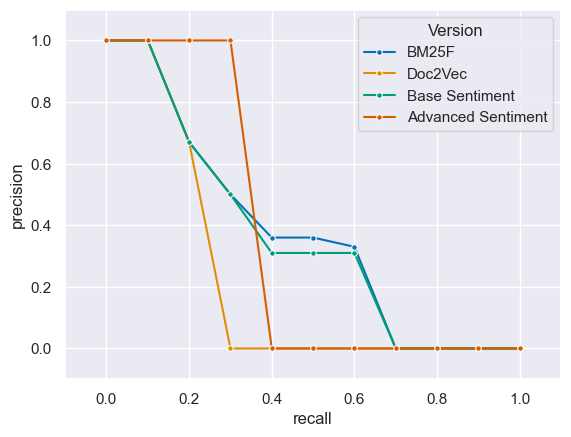

In [33]:
# define axes' names
axes = ["recall", "precision"]

# create a dataframe for Seaborn
df = pd.DataFrame()

for model, model_name in models:
    result = b.getResults(20, model)
    
    # get precision at standard recall values over list of result
    SRLValues = b.getSRLValues(
        b.getPrecisionValues(result),
        b.getRecallValues(result)
    )
    
    # tmp dataframe concatenated to the main one
    dfB = pd.DataFrame(SRLValues, columns = axes)
    dfB["Version"] = f'{model_name}'
    
    df = pd.concat([df, dfB])

sns.set_theme()


# plot the line graph
pltP = sns.lineplot(data = df, x = 'recall', y = 'precision', marker='o', markersize=4, 
            hue="Version", palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltP.set_xlim([-0.1, 1.1]);
pltP.set_ylim([-0.1, 1.1]);
    

### Interpolated Average Precision (IAP) at Standard Recall Leveles

Interpolated Average Precision for each query is computed using 

$\sum_{r=0}^{n} \frac{P_q(r)}{n}$

where $P_q(r)$ is the interpolated precision at the level $r$, for n+1 standard recall levels.

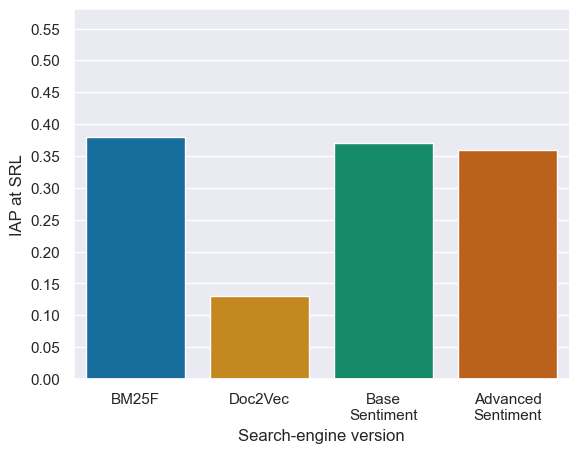

In [34]:
from matplotlib.ticker import MultipleLocator
import textwrap

versions = [] 
AvPr_values=[]

for model, model_name in models:
    result = b.getResults(20, model)
    SRLValues = b.getSRLValues(
        b.getPrecisionValues(result),
        b.getRecallValues(result)
    )
    
    AvPr_values.append(b.getIapAvgPrecision(SRLValues))
    
    versions.append(textwrap.fill(model_name, width=10,
                    break_long_words=True))
    
# plot the average precisi+ons
# apply the default theme
sns.set_theme()


# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, "IAP at SRL": AvPr_values})

# plot the bar graph
pltAvPr = sns.barplot(data = df, x = "Search-engine version", y = 'IAP at SRL',palette="colorblind")


# set fixed axes, the semicolon suppress the output
pltAvPr.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltAvPr.yaxis.set_major_locator(MultipleLocator(0.05))

### R-Precision

Calculate how many relevant documents I have returned compared to the ideal case in which in the first $n$ documents are all relevants. 

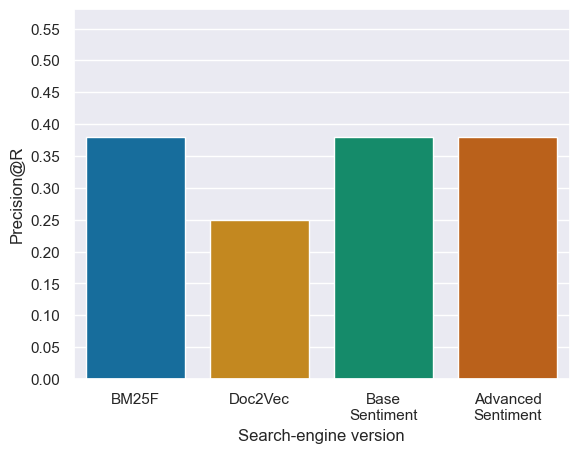

In [35]:
versions = [] 
RP_values=[]

for model, model_name in models:
    result = b.getResults(20, model)
    
    RP_values.append(b.getRPrecision(result))
    
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# plot the average precisi+ons
# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'Precision@R': RP_values})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'Precision@R', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))

### Mean Average Precision (MAP)

Firstly, get Non-Interpolated Average Precision for each query using $ \sum_{r=0}^{n} \frac{P_q(r/|R_q|)}{|R_q|} $


In [36]:

NIAP_dict = {}

for q in queries:
    
    tmpB = Benchmark(q)
    
    for model, model_name in models:
        result = tmpB.getResults(20, model)
        
        NIAP_dict.setdefault(model_name, []).append(tmpB.getNIapAvgPrecision(
            tmpB.getPrecisionValues(result),
            tmpB.getRecallValues(result)
        ))


Secondly, compute Mean Average Precision for every model which is just an average between all the NIAP. 

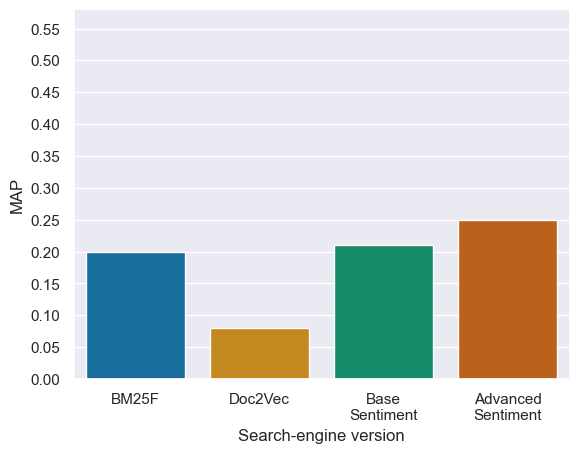

In [37]:
MAP_list = []
versions = []

for model_name, p_list in NIAP_dict.items():
    MAP_list.append(round(sum(p_list)/len(p_list),2) if len(p_list) != 0 else 0)
            
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'MAP': MAP_list})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'MAP', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))


### F-Measure & E-Measure 

E-measure is a variant of the harmonic mean which allows us to emphasize the value of recall or precision based on what we are interested in:

- $b=1 \rightarrow 1-\text{F-Measure}$ 
- $b>1$ emphasize precision
- $b<1$ emphasize recall

*Precision or Recall?*

- High Recall: relevant documents, but with too many unrelevant documents. 
- High Precision: few results but with an greater probability of being relevant. 

It's possible to customize *b* value.

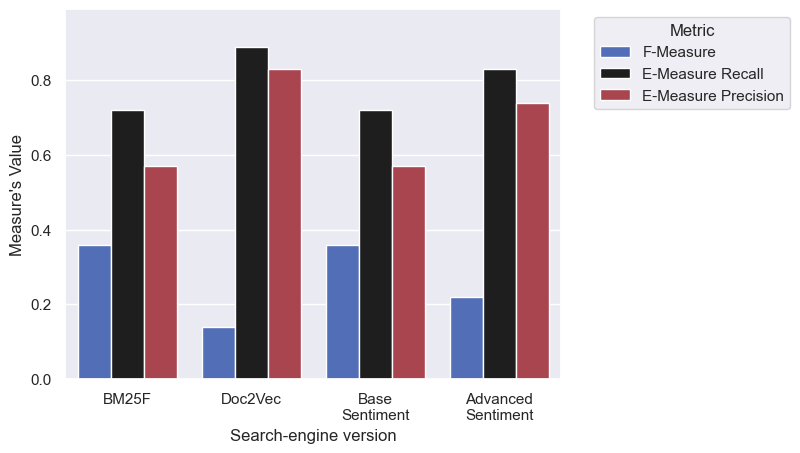

In [38]:

b_recall = 0.5          # Default value for emphasizing recall
b_precision = 1.5       # Default value for emphasizing precision

df = pd.DataFrame(columns=["Search-engine version"])
for model, model_name in models:    
    result = b.getResults(20, model)

    data = {
    'F-Measure': [b.getFMeasure(result)],
    'E-Measure Recall': [b.getEMeasure(result, b_recall)],
    'E-Measure Precision': [b.getEMeasure(result, b_precision)]
    }

    tmpDf = pd.DataFrame(data)
    tmpDf["Search-engine version"] = textwrap.fill(model_name, width=10,
                break_long_words=True)
    
    df = pd.concat([df, tmpDf])
    

# apply the default theme
sns.set_theme()

df_long = df.melt(id_vars='Search-engine version', var_name='Metric', value_name='Measure\'s Value')

# Crea il barplot
pltMeasures = sns.barplot(x='Search-engine version', y='Measure\'s Value', hue='Metric', data=df_long, palette='icefire')
pltMeasures.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')


# set fixed axes, the semicolon suppress the output
pltMeasures.set_ylim([0.0, df.iloc[:, -3:].max().max()+0.1]); # set y-axis    